In this notebook we will include an extra analysis to the paper. We will compare how well the *optimal* strategy performs in terms of both trading speed and generated cash, compared to different quote strategies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *

In [2]:
def compute_safe_quotes(q_max, N, slope):
    """
    We define a "safe" trader that posts conservative (negative) quotes that increase (in absolute value) with the inventory, aiming to execute fast at the cost of earning less cash
    """
    quotes = np.zeros((q_max+1, N+1))
    for q in range(1, q_max+1):
        quotes[q,:] = -slope * q
    return quotes

def compute_greedy_quotes(q_max, N, delta_const):
    """
    We define a "greedy" trader that always posts a positive quote, regardless of the inventory level, at the cost on increasing both market and execution risk
    """
    quotes = np.full((q_max+1, N+1), delta_const)
    quotes[0, :] = 0.0
    return quotes

def compute_random_quotes(q_max, N, low, high):
    """
    We define a "random" trader that posts random quotes that he chooses between some low and high levels
    """
    quotes = np.random.uniform(low, high, (q_max+1, N+1))
    quotes[0, :] = 0.0
    return quotes


Parameters

In [3]:
q_max = 6
T = 300.0     # 5 minutes in seconds
N = 500
dt = T / N

# Baseline model parameters
A = 0.1
k = 0.3
gamma = 0.05
b = 3.0
mu = 0.0
sigma = 0.3

alpha = 0.5 * k * gamma * (sigma**2)
beta = k * mu
eta = A * (1 + gamma/k)**(-(1 + k/gamma))

Compute the quotes

In [4]:
# Optimal Strategy
pde_quotes = compute_optimal_quote(q_max, N, k, b, alpha, beta, gamma, eta, dt)

# Safe Strategy
safe_quotes = compute_safe_quotes(q_max, N, slope=1.5)

# Greedy Strategy
greedy_quotes = compute_greedy_quotes(q_max, N, delta_const=7.5)

# Random Strategy
random_quotes = compute_random_quotes(q_max, N, low=-5, high=5)

Simulation

In [5]:
M = 10**5
q_init = 6
S_init = 100.0

q_paths_opt, S_paths_opt, X_paths_opt = simulate_trading_paths(M, N, dt, q_init, S_init, mu, sigma, k, gamma, pde_quotes, A, b)
q_paths_safe, S_paths_safe, X_paths_safe = simulate_trading_paths(M, N, dt, q_init, S_init, mu, sigma, k, gamma, safe_quotes, A, b)
q_paths_greedy, S_paths_greedy, X_paths_greedy = simulate_trading_paths(M, N, dt, q_init, S_init, mu, sigma, k, gamma, greedy_quotes, A, b)
q_paths_random, S_paths_random, X_paths_random = simulate_trading_paths(M, N, dt, q_init, S_init, mu, sigma, k, gamma, random_quotes, A, b)

Plot the results

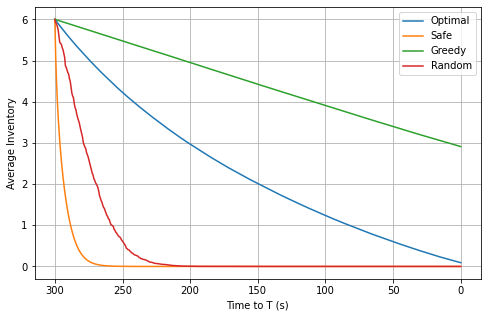

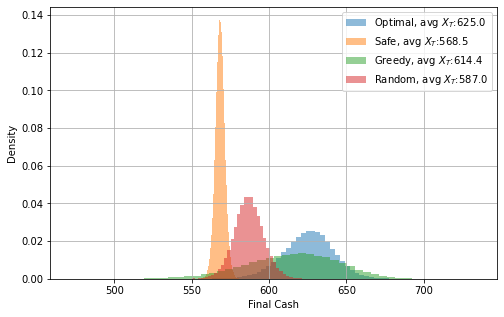

In [6]:
# Trading curves

time_grid = np.linspace(T, 0, N+1) # backward grid: from T to 0
avg_q_opt = np.mean(q_paths_opt, axis=1)
avg_q_safe = np.mean(q_paths_safe, axis=1)
avg_q_greedy = np.mean(q_paths_greedy, axis=1)
avg_q_random = np.mean(q_paths_random, axis=1)

plt.figure(figsize=(8,5))
plt.plot(time_grid, avg_q_opt, label='Optimal')
plt.plot(time_grid, avg_q_safe, label='Safe')
plt.plot(time_grid, avg_q_greedy, label='Greedy')
plt.plot(time_grid, avg_q_random, label='Random')
plt.xlabel('Time to T (s)')
plt.ylabel('Average Inventory')
# plt.title('Trading Curve (Average Inventory vs. Time)')
plt.legend()
plt.gca().invert_xaxis() 
plt.grid(True)
plt.savefig("./Figures/strategies_comparison_trading_curve.png")


# Final cash distribution

final_cash_opt = X_paths_opt[-1,:]
final_cash_safe = X_paths_safe[-1,:]
final_cash_greedy = X_paths_greedy[-1,:]
final_cash_random = X_paths_random[-1,:]

plt.figure(figsize=(8,5))
plt.hist(final_cash_opt, bins=50, alpha=0.5, label=r'Optimal, avg $X_T$:'+f'{round(np.mean(final_cash_opt),1)}', density=True)
plt.hist(final_cash_safe, bins=50, alpha=0.5, label=r'Safe, avg $X_T$:'+f'{round(np.mean(final_cash_safe),1)}', density=True)
plt.hist(final_cash_greedy, bins=50, alpha=0.5, label=r'Greedy, avg $X_T$:'+f'{round(np.mean(final_cash_greedy),1)}', density=True)
plt.hist(final_cash_random, bins=50, alpha=0.5, label=r'Random, avg $X_T$:'+f'{round(np.mean(final_cash_random),1)}', density=True)
plt.xlabel('Final Cash')
plt.ylabel('Density')
# plt.title('Distribution of Final Cash')
plt.legend()
plt.grid(True)
plt.savefig("./Figures/strategies_comparison_pnl.png")